In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.autograd import Variable
import time
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


In [2]:
# Set up place to download pretrained model from internet
import os
os.environ['TORCH_HOME'] = '../models/pretrained/'

In [4]:
processed_path = "../data/processed/"
print("Loading data ....")
train_loader = torch.load(processed_path+)
valid_loader = torch.
test_loader = torch.load()
print("Done!")

Loading data ....
Done!


In [9]:
model = models.resnet50(pretrained=True)
# print(model)

In [6]:
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ("output", nn.Linear(2048, 1))
]))

model.fc = fc

#Move model to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
base_learning_rate = 1e-5
epochs = 1
weight_decay = 0.0005
gamma = 0.001
power = 0.75
criterion = nn.SmoothL1Loss().to(device)
train_losses, valid_losses = [], []
steps = 0

In [8]:
#training model
for epoch in range(epochs):
    running_loss = 0
    learning_rate = base_learning_rate*(1+gamma*epoch)**(-power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    
    for images, _, _, bmi in train_loader:
        # Reset optimizer
        optimizer.zero_grad()

        #Send data to GPU
        images = images.to(device)
        bmi = bmi.to(device)

        #Training model
        predictions = model(images)
        loss = criterion(predictions, bmi)
        
        #Backpropagation
        loss.backward()

        #Update weight
        optimizer.step()
    
        #Calculate running loss
        running_loss += loss.item()
    else:
        validating_loss = 0

        #Turn off the gradient descent, save memory and computations
        with torch.no_grad():
            for images, _, _, bmi in valid_loader:

                #Move data to GPU
                images = images.to(device)
                bmi = bmi.to(device)
                #Run model
                predictions = model(images)
                loss = criterion(predictions, bmi)
                validating_loss += loss.item()
    
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(validating_loss/len(valid_loader))

        print(
            "Epoch: {}/{}..".format(epoch+1, epochs),
            "Training loss: {:.3f}".format(running_loss/len(train_loader)),
            "Validating loss: {:.3f}".format(validating_loss/len(valid_loader))
            )

RuntimeError: CUDA error: no kernel image is available for execution on the device

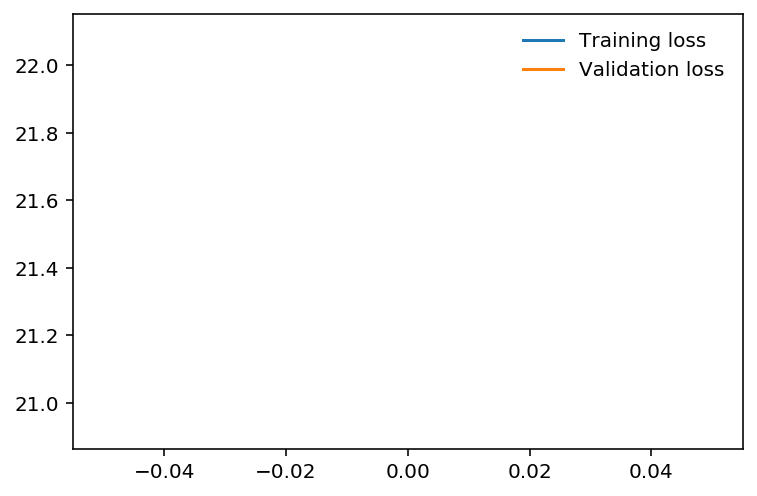

In [10]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend(frameon=False);